In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# Modulation Measurement

Match the amplitude of the signal with the modulation.

# Magnet Measurement

In this section we measure the signal response of the magnetometer to a magnet modelled as a cilinder.

## Theoretical Model

We model the stacked magnets as uniformly magnetized solid cylinders with axial magnetization along the $z$ axis. The total magnetic field is obtained by summing the contribution of each individual magnet.

The assumptions for this model are:

* Each magnet is a solid cylinder with radius ($R$) and thickness ($L$).
* The magnetization is uniform and oriented along the cylinder axis.
* The material is characterized by its remanent flux density (B_r).
* Magnets are stacked along the (z)-axis with a fixed spacing (air or plastic gap) between them.
* Magnetic interactions between magnets and external materials are neglected (superposition approximation).
* The field is computed only along the symmetry axis.


Using the equivalent surface magnetic charge model, an axially magnetized cylinder produces an axial field:

$$
B_z(z)=\frac{B_r}{2}
\left[
    \frac{z+L}{\sqrt{(z+L)^2+R^2}}
\frac{z}{\sqrt{z^2+R^2}}
\right]
$$

where (z) is measured from the lower face of the magnet.

This expression results from the difference between the fields produced by the two magnetized end faces.

A stack of $N$ magnets is modeled by placing each cylinder at its corresponding axial position and summing their contributions:

$$
B_{\text{total}}(z)=\sum_{i=1}^{N} B_i(z)
$$

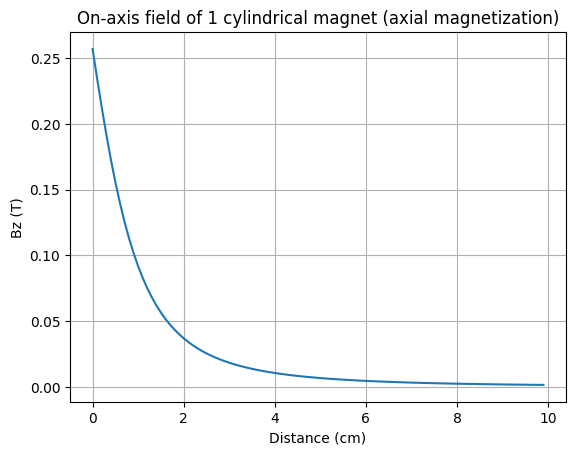

Magnetic Field at z=0 from the top of the magnet stack: 0.25711 T


In [ ]:
def bz_cylinder_on_axis(z_m, z0_m, L_m, R_m, Br_T):
    """
    Axial magnetic flux density Bz (Tesla) of a uniformly axially-magnetized
    *solid cylindrical* permanent magnet, evaluated on the symmetry axis.

    Parameters
    ----------
    z_m : float or np.ndarray
        Observation position(s) along the z-axis [m].
    z0_m : float
        z-position of the magnet's *bottom face* [m].
    L_m : float
        Magnet thickness (height along z) [m].
    R_m : float
        Cylinder radius [m].
    Br_T : float
        Remanent flux density of the magnet material [T].

    Returns
    -------
    Bz_T : float or np.ndarray
        Axial magnetic flux density on-axis [T].
    """
    z = np.asarray(z_m) - z0_m  # coordinate relative to the magnet bottom face

    return 0.5 * Br_T * (
        (z + L_m) / np.sqrt((z + L_m)**2 + R_m**2)
        - z / np.sqrt(z**2 + R_m**2)
    )


def bz_stack_cylinders(distance_cm,
                       n_magnets=10,
                       gap_mm=0.5,
                       Br_T=1.45,
                       OD_mm=25.0,
                       thickness_mm=3.0,
                       z_reference="top"):
    """
    Total on-axis field (nT) from a stack of solid cylindrical magnets.

    The stack is modeled as N identical axially magnetized cylinders, separated
    by a constant gap. The total field is the linear superposition of each
    magnet's on-axis field.

    Parameters
    ----------
    distance_cm : float or np.ndarray
        Distance(s) from the chosen reference plane [cm].
    z_reference : {"top","bottom","center"}
        "top"    : distance measured from the stack top face outward (+z)
        "bottom" : distance measured from the stack bottom face outward (+z)
        "center" : distance measured from the stack geometric center (+z)
    OD_mm : float
        Outer diameter of the cylinder [mm] (used to compute radius).
    thickness_mm : float
        Thickness of each magnet [mm].
    gap_mm : float
        Gap between adjacent magnets [mm].

    Returns
    -------
    B_total_nT : float or np.ndarray
        Total axial field on the stack axis [nT].
    """
    # Geometry in meters
    R = (OD_mm / 2.0) * 1e-3
    L = thickness_mm * 1e-3
    gap = gap_mm * 1e-3

    pitch = L + gap
    total_height = n_magnets * L + (n_magnets - 1) * gap

    d = np.asarray(distance_cm, dtype=float) * 1e-2  # cm -> m

    # Define stack coordinates: first magnet bottom at z0_first, point at z_point
    if z_reference == "top":
        z0_first = 0.0
        z_point = total_height + d
    elif z_reference == "bottom":
        z0_first = 0.0
        z_point = d
    elif z_reference == "center":
        z0_first = -total_height / 2.0
        z_point = total_height / 2.0 + d
    else:
        raise ValueError("z_reference must be one of: 'top', 'bottom', 'center'")

    # Sum contributions (vectorized over z_point; loop only over magnets)
    B_total_T = np.zeros_like(z_point, dtype=float)
    for i in range(n_magnets):
        z0_i = z0_first + i * pitch
        B_total_T += bz_cylinder_on_axis(z_point, z0_i, L, R, Br_T)

    return B_total_T * 1e9  # Tesla -> nT


# ---- Example: plot field for a single cylinder referenced from the bottom face ----
X = np.arange(0, 10, 0.1)  # cm
B_z = bz_stack_cylinders(distance_cm=X,
                          n_magnets=10,
                          gap_mm=5.0,
                          Br_T=1.45,
                          OD_mm=25.0,
                          thickness_mm=3.0,
                          z_reference="top") * 1e-09  # nT -> T

plt.plot(X, B_z)
plt.xlabel("Distance (cm)")
plt.ylabel("Bz (T)")
plt.title("On-axis field of 1 cylindrical magnet (axial magnetization)")
plt.grid(True)
plt.show()

# ---- Example: field at 0 cm from the bottom of a 10-magnet stack (reported in Tesla) ----
B0_T = bz_stack_cylinders(distance_cm=0,
                          n_magnets=10,
                          gap_mm=5.0,
                          Br_T=1.45,
                          OD_mm=25.0,
                          thickness_mm=3.0,
                          z_reference="top") * 1e-9  # nT -> T
print("Magnetic Field at z=0 from the top of the magnet stack:", B0_T.round(5), "T")


## Experimental data

By moving the magnet in the z axis closer to the magnetometer, we found different signal data.

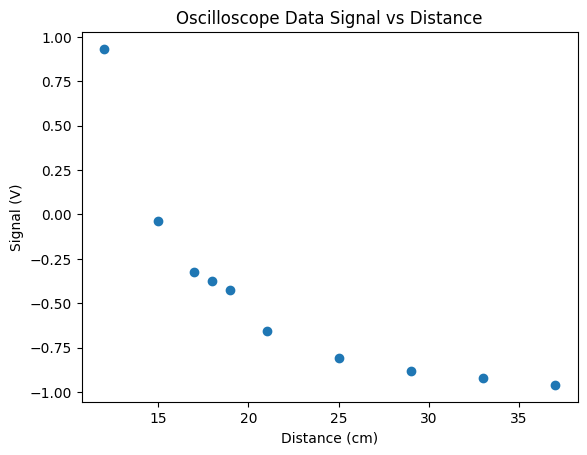

In [ ]:
distances = [12,15,17,18,19,21,25,29,33,37]
means = []
for i in distances:
    data_t = pd.read_csv(f"im/RigolDSim{i}.csv")
    means.append(-data_t["CH1(V)"].mean())

plt.scatter(distances, means, color="orange")
plt.title("Oscilloscope Data Signal vs Distance")
plt.xlabel("Distance (cm)")
plt.ylabel("Signal (V)")
# plt.yscale('log')
plt.show()

## Adjusting the data

Now we adjust the measured data to find a relation between the signal and the magnetic field it corresponds to.

In [54]:
def calibrate_linear(dist_cm, volt, **model_kwargs):
    """
    Linear calibration of magnetometer voltage vs theoretical magnetic field.

    Fits a linear model:
        V = a * B + b

    Parameters
    ----------
    dist_cm : array-like
        Distances from the magnet stack [cm].
    volt : array-like
        Measured voltages from the magnetometer [V].
    model_kwargs : dict
        Parameters passed to the magnetic field model
        (e.g., gap_mm, Br_T, etc.).

    Returns
    -------
    dict
        a_V_per_nT : sensor gain [V/nT]
        b_V        : voltage offset [V]
        a_err      : uncertainty of gain
        b_err      : uncertainty of offset
    """

    dist_cm = np.asarray(dist_cm, dtype=float)
    volt = np.asarray(volt, dtype=float)

    # Compute theoretical magnetic field (nT) for each distance
    B_nT = np.array([bz_stack_cylinders(d, **model_kwargs) for d in dist_cm])

    # Linear model: V = a*B + b
    def V_model(B, a, b):
        return a * B + b

    # Fit model parameters
    (a, b), cov = curve_fit(V_model, B_nT, volt)
    a_err, b_err = np.sqrt(np.diag(cov))

    return {
        "a_V_per_nT": a,
        "b_V": b,
        "a_err": a_err,
        "b_err": b_err
    }
curve = calibrate_linear(distances, means, 
                         # Model Arguments
                         n_magnets=10, gap_mm=0.5, Br_T=1.45, OD_mm=25, thickness_mm=3, z_reference="top"
                         )
print(curve)

{'a_V_per_nT': np.float64(1.5609083391158716e-06), 'b_V': np.float64(-1.061564072828546), 'a_err': np.float64(3.665488982083981e-08), 'b_err': np.float64(0.019259868544106964)}


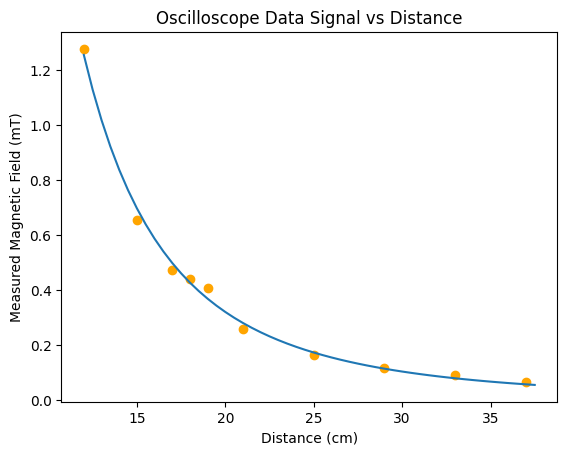

In [66]:
distances_full_range = np.arange(min(distances),max(distances)+1,0.5) 
theoretical_Bz = bz_stack_cylinders(distance_cm=distances_full_range,
                             n_magnets=10,
                             gap_mm=0.5,     
                             Br_T=1.45,      
                             OD_mm=25.0,
                             thickness_mm=3.0,
                             z_reference="top")

plt.plot(distances_full_range, theoretical_Bz *1e-6)
plt.scatter(distances, (np.array(means)-curve['b_V'])/curve['a_V_per_nT'] *1e-6, color="orange")
plt.title("Oscilloscope Data Signal vs Distance")
plt.xlabel("Distance (cm)")
plt.ylabel("Measured Magnetic Field (mT)")
# plt.yscale('log')
plt.show()